In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataset_builder as db
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[2,11],
    ACT_LABELS[1]:[4,12],
    ACT_LABELS[2]:[7,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13],
}

In [2]:
import tensorflow as tf 
import keras 
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from collections import Counter

from keras import regularizers
from keras.models import Sequential, Model, load_model, model_from_json 
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Reshape, Concatenate,  Dropout 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["rotationRate", "userAcceleration"]
mode = "mag"
ep = 100
cga = True # Add gravity to acceleration or not

print("[INFO] -- Selected sensor data types: "+str(sdt)+" -- Mode: "+str(mode)+" -- Grav+Acc: "+str(cga))    
act_labels = ACT_LABELS [0:4]

print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = db.set_data_types(sdt)
dataset = db.creat_time_series(dt_list, act_labels, trial_codes, mode=mode, labeled=True, combine_grav_acc = cga)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    


#*****************
TRAIN_TEST_TYPE = "trial" # "subject" or "trial"
#*****************

if TRAIN_TEST_TYPE == "subject":
    test_ids = [4,9,11,21]
    print("[INFO] -- Test IDs: "+str(test_ids))
    test_ts = dataset.loc[(dataset['id'].isin(test_ids))]
    train_ts = dataset.loc[~(dataset['id'].isin(test_ids))]
else:
    test_trail = [11,12,13,14,15,16]  
    print("[INFO] -- Test Trials: "+str(test_trail))
    test_ts = dataset.loc[(dataset['trial'].isin(test_trail))]
    train_ts = dataset.loc[~(dataset['trial'].isin(test_trail))]

print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(test_ts.shape))

print(train_ts.head())

[INFO] -- Selected sensor data types: ['rotationRate', 'userAcceleration'] -- Mode: mag -- Grav+Acc: True
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(538839, 9)
[INFO] -- Test Trials: [11, 12, 13, 14, 15, 16]
[INFO] -- Shape of Train Time-Series :(393152, 9)
[INFO] -- Shape of Test Time-Series :(145687, 9)
   rotationRate  userAcceleration  act   id  weight  height   age  gender  \
0      1.934974          0.848353  0.0  0.0   102.0   188.0  46.0     1.0   
1      0.948655          0.845879  0.0  0.0   102.0   188.0  46.0     1.0   
2      1.558111          0.650129  0.0  0.0   102.0   188.0  46.0     1.0   
3      2.549060          0.694418  0.0  0.0   102.0   188.0  46.0     1.0   
4      3.006681          0.652475  0.0  0.0   102.0   188.0  46.0     1.0   

   trial  
0    2.0  
1    2.0  
2    2.0  
3    2.0  
4    2.0  


In [4]:
## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
w = 64 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
s = 8
train_data, act_train, id_train, train_mean, train_std = db.ts_to_secs(train_ts.copy(),
                                                                   w,
                                                                   s,
                                                                   standardize = True)

s = 8
test_data, act_test, id_test, test_mean, test_std = db.ts_to_secs(test_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)

print("[INFO] -- Shape of Training Sections: "+str(train_data.shape))
print("[INFO] -- Shape of Test Sections:  "+str(test_data.shape))


id_train_labels = to_categorical(id_train)
id_test_labels = to_categorical(id_test)
act_train_labels = to_categorical(act_train)
act_test_labels = to_categorical(act_test)
## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
train_data = np.expand_dims(train_data,axis=3)
print("[INFO] -- Shape of Training Sections:", train_data.shape)
test_data = np.expand_dims(test_data,axis=3)
print("[INFO] -- Shape of Training Sections:", test_data.shape)

height = train_data.shape[1]
width = train_data.shape[2]

id_class_numbers = 24
act_class_numbers = len(np.unique(act_train))

[INFO] -- Training Data has been standardized: the mean is = [2.34393788 1.24353595] ; and the std is = [1.53834876 0.77958712]
[INFO] -- Test Data has been standardized
[INFO] -- Shape of Training Sections: (48390, 2, 64)
[INFO] -- Shape of Test Sections:  (17453, 2, 64)
[INFO] -- Shape of Training Sections: (48390, 2, 64, 1)
[INFO] -- Shape of Training Sections: (17453, 2, 64, 1)


In [5]:
class Encoder:
    l2p = 0.0005
    @staticmethod
    def layers(x, fm, act_func="linear", hid_act_func="relu"):
        x = Conv2D(32, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        
        x = Conv2D(32, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)
        
        x = Conv2D(32, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        
        x = Conv2D(32, fm, activation=hid_act_func,kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)
        
        x = Conv2D(32, fm, activation=hid_act_func,kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(1, fm, activation=act_func, padding='same')(x) 
        y = BatchNormalization()(x)

        return y
   
    @staticmethod
    def build(height, width, fm, act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        enc = Encoder.layers(inp, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=enc ,name="Encoder")
        return model

class Decoder:
    l2p = 0.0005
    @staticmethod
    def layers(y, height, width, fm, act_func="linear", hid_act_func="relu"):
        
        x = Conv2DTranspose(32, fm, strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(y)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(32, fm, strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        
        xh = Conv2D(1, fm, activation=act_func, padding='same')(x)
        return xh
   
    @staticmethod
    def build(height, width, fm , act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        dec  = Decoder.layers(inp,height, width, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=dec ,name="Decoder")
        return model

In [6]:
fm = (2,5)
enc = Encoder.build(height, width, fm, act_func="linear", hid_act_func="relu")
dec = Decoder.build(height, width//32, fm, act_func="linear", hid_act_func="relu")
enc.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
dec.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
inp = Input(shape=(height, width,1))
x = enc(inp)
z = dec(x)
cae = Model(inputs=inp, outputs=z)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
filepath="msda_64_to_2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, early_stop]

cae.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])

cae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 64, 1)          0         
_________________________________________________________________
Encoder (Model)              (None, 2, 2, 1)           42405     
_________________________________________________________________
Decoder (Model)              (None, 2, 64, 1)          42401     
Total params: 84,806
Trainable params: 84,164
Non-trainable params: 642
_________________________________________________________________


In [7]:
cae.fit(train_data, train_data,
        validation_data = (test_data, test_data),
        epochs = ep,
        batch_size = 128,
        verbose = 0,
        callbacks = callbacks_list
       )

cae.load_weights("msda_64_to_2.best.hdf5")
cae.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])


Epoch 00001: val_loss improved from inf to 0.69903, saving model to msda_64_to_2.best.hdf5

Epoch 00002: val_loss improved from 0.69903 to 0.58523, saving model to msda_64_to_2.best.hdf5

Epoch 00003: val_loss improved from 0.58523 to 0.52866, saving model to msda_64_to_2.best.hdf5

Epoch 00004: val_loss improved from 0.52866 to 0.51431, saving model to msda_64_to_2.best.hdf5

Epoch 00005: val_loss improved from 0.51431 to 0.48787, saving model to msda_64_to_2.best.hdf5

Epoch 00006: val_loss improved from 0.48787 to 0.47741, saving model to msda_64_to_2.best.hdf5

Epoch 00007: val_loss improved from 0.47741 to 0.45778, saving model to msda_64_to_2.best.hdf5

Epoch 00008: val_loss did not improve from 0.45778

Epoch 00009: val_loss did not improve from 0.45778

Epoch 00010: val_loss improved from 0.45778 to 0.45164, saving model to msda_64_to_2.best.hdf5

Epoch 00011: val_loss did not improve from 0.45164

Epoch 00012: val_loss improved from 0.45164 to 0.44127, saving model to msda_64

In [8]:
lv_y_train = enc.predict(train_data)
lv_y_test  = enc.predict(test_data)

print("[INFO] -- Shape tz_train:"+str(lv_y_train.shape))
print("[INFO] --  Shape tz_test :"+str(lv_y_test.shape))

[INFO] -- Shape tz_train:(48390, 2, 2, 1)
[INFO] --  Shape tz_test :(17453, 2, 2, 1)


In [9]:
lv_y_train_flat = lv_y_train.reshape(lv_y_train.shape[0], lv_y_train.shape[1], lv_y_train.shape[2]*lv_y_train.shape[3])
lv_y_test_flat = lv_y_test.reshape(lv_y_test.shape[0], lv_y_test.shape[1], lv_y_test.shape[2]*lv_y_test.shape[3])
print("[INFO] -- Shape tz_train:"+str(lv_y_train_flat.shape))
print("[INFO] --  Shape tz_test :"+str(lv_y_test_flat.shape))

[INFO] -- Shape tz_train:(48390, 2, 2)
[INFO] --  Shape tz_test :(17453, 2, 2)


In [10]:
x_2d_train = lv_y_train_flat[:,0,:]
x_2d_test = lv_y_test_flat[:,0,:]

Text(0.04,0.5,'second component of Y')

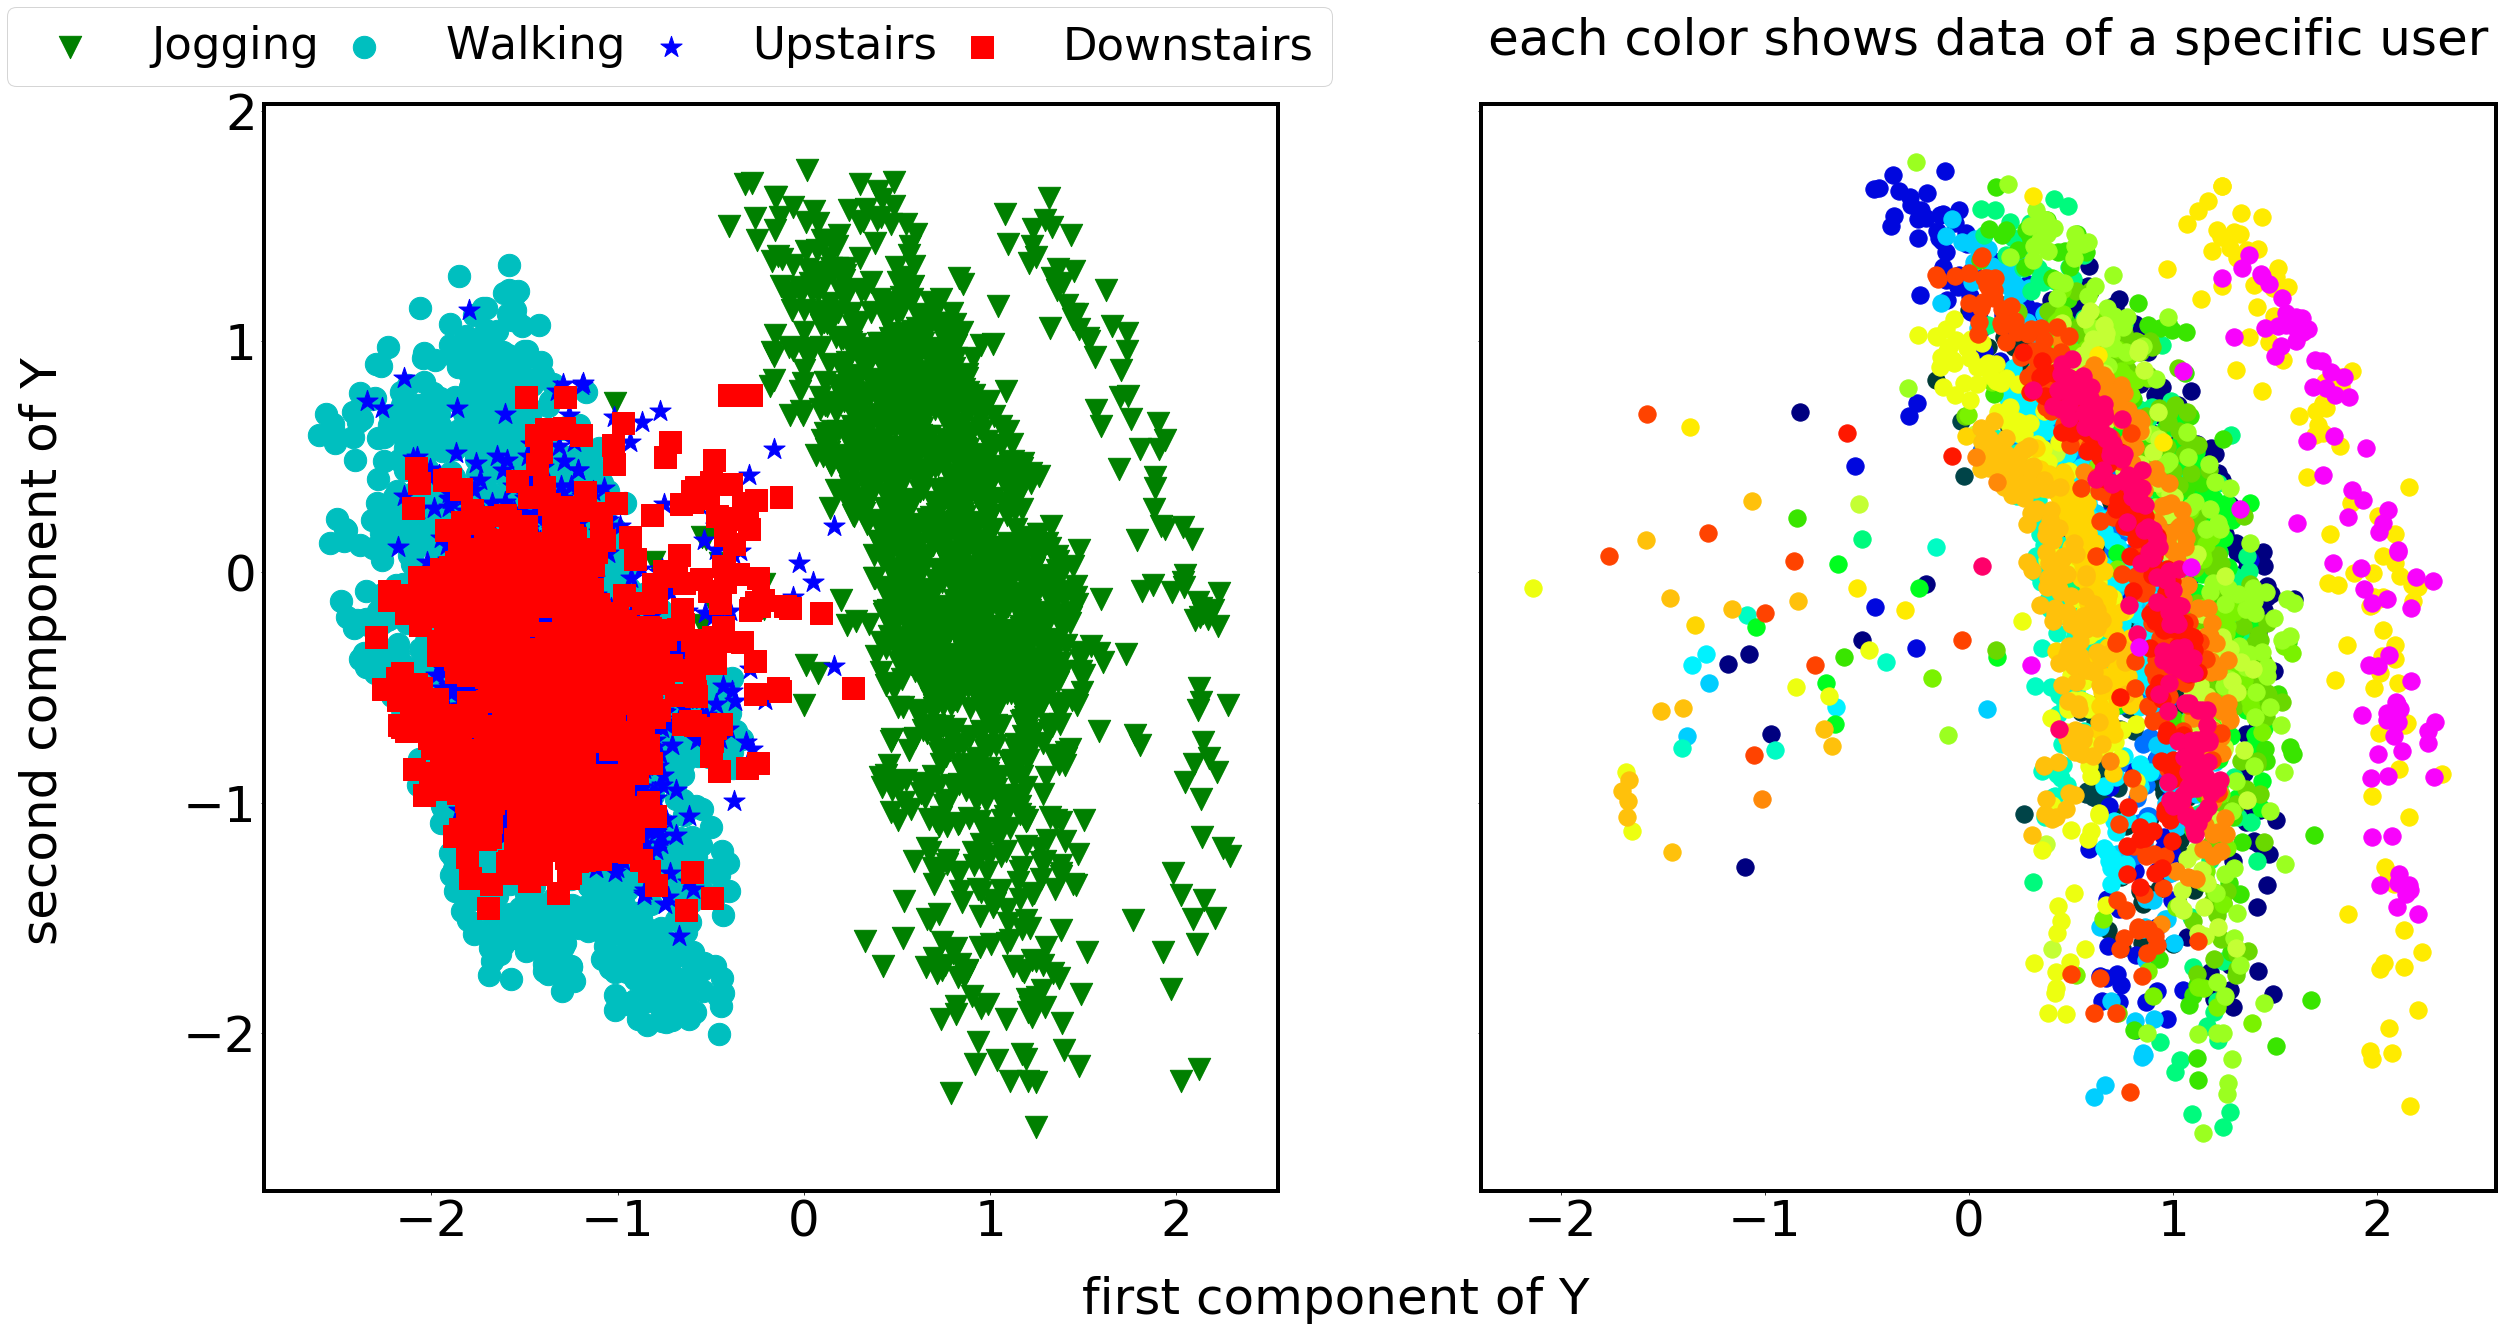

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

plt.rcParams['figure.figsize'] = (40,20)
plt.rcParams['font.size'] = 50
plt.rcParams['axes.linewidth'] = 4

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')


colors = ['r','b','c','g','k','m']
classes = ["Downstairs","Upstairs", "Walking", "Jogging", "Stand-Up", "Sat"]
markers = ["s", "*", "o", "v", "p", "^"]
for i in [3,2,1,0]:
    x = ((x_2d_train[act_train == i])[:,0])[::8]
    y = ((x_2d_train[act_train == i])[:,1])[::8]
    ax[0].scatter(x, y, c=colors[i], label=classes[i], marker = markers[i], alpha=1.0, s = 500)
ax[0].legend(bbox_to_anchor=(-0.275, 1.01, 1.35, .1), mode="expand",ncol=4, fontsize=45)    
#plt.xlabel("t-SNE component 1 (normalized uints)",fontsize = 45)
#plt.ylabel("t-SNE component 2 (normalized uints)",fontsize = 45)

n = 30
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0., 1.01, 1./(n-1.))]

act = 3

for i in range(24):
    x = ((x_2d_train[np.logical_and(id_train == i, act_train == act)])[:,0])[::4]
    y = ((x_2d_train[np.logical_and(id_train == i, act_train == act)])[:,1])[::4]
    ax[1].scatter(x, y, c=colors[i], label="u_"+str(i+1), alpha=1., s = 300)
ax[1].set_title("each color shows data of a specific user", y=1.04, fontsize=50)
# plt.xlabel("t-SNE component 1 (normalized uints)")
# plt.ylabel("t-SNE component 2 (normalized uints)")
fig.text(0.5, 0.04, 'first component of Y ', ha='center',fontsize=50)
fig.text(0.04, 0.5, 'second component of Y', va='center', rotation='vertical', fontsize=50)
